The top 20 conditions of XGBoost obtained using 120 descriptors 
Predicting reaction performance in C–N cross-coupling using machine learning
Experimental data obtained from Ahneman et al publication in Science DOI: 10.1126/science.aar5169
                    

                                                 Gashaw M. Goshu, September 26, 2020

In [1]:
# Import relevant libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sn
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import utils
%matplotlib inline

In [2]:
# open a file containing descriptors and yield
data = pd.read_csv("Descriptor_and_yield_table.csv")


In [3]:
data

,additive_*C3_NMR_shift,additive_*C3_electrostatic_charge,additive_*C4_NMR_shift,additive_*C4_electrostatic_charge,additive_*C5_NMR_shift,additive_*C5_electrostatic_charge,additive_*N1_electrostatic_charge,additive_*O1_electrostatic_charge,additive_E_HOMO,additive_E_LUMO,...,ligand_V6_frequency,ligand_V6_intensity,ligand_V7_frequency,ligand_V7_intensity,ligand_V8_frequency,ligand_V8_intensity,ligand_V9_frequency,ligand_V9_intensity,ligand_dipole_moment,yield
0,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,-0.0487,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,10.657812
1,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,-0.0487,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,14.747896
2,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,-0.0487,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,18.278686
3,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,-0.0487,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,2.475058
4,143.12,0.223,93.06,-0.447,162.34,0.292,-0.334,-0.057,-0.2317,-0.0487,...,1640.307,4.414,3026.561,16.577,3043.097,18.145,3064.344,38.210,1.212924,6.119058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,-0.0696,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,57.426670
3956,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,-0.0696,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,86.233157
3957,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,-0.0696,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,1.440081
3958,152.98,0.429,98.09,-0.589,159.31,0.387,-0.350,-0.068,-0.2337,-0.0696,...,1631.618,37.445,3025.675,16.220,1054.500,1.432,3041.406,35.621,3.735286,43.538365


In [4]:
features =["additive_*C3_NMR_shift",
            "aryl_halide_*C3_NMR_shift","aryl_halide_*H2_electrostatic_charge",
            "base_*N1_electrostatic_charge","ligand_*C11_NMR_shift",
            "additive_*C4_electrostatic_charge","base_E_HOMO","aryl_halide_V2_frequency",
            "aryl_halide_E_LUMO","additive_E_LUMO"
            ]
X_data = data[features] # the 10 descriptors gave better prediction than the published paper.
y_data = data['yield'] # Yield of the 3560 rows is stored in the y_data variable

In [5]:
data.isna().sum()

additive_*C3_NMR_shift               0
additive_*C3_electrostatic_charge    0
additive_*C4_NMR_shift               0
additive_*C4_electrostatic_charge    0
additive_*C5_NMR_shift               0
                                    ..
ligand_V8_intensity                  0
ligand_V9_frequency                  0
ligand_V9_intensity                  0
ligand_dipole_moment                 0
yield                                0
Length: 121, dtype: int64

In [6]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   additive_*C3_NMR_shift                3960 non-null   float64
 1   aryl_halide_*C3_NMR_shift             3960 non-null   float64
 2   aryl_halide_*H2_electrostatic_charge  3960 non-null   float64
 3   base_*N1_electrostatic_charge         3960 non-null   float64
 4   ligand_*C11_NMR_shift                 3960 non-null   float64
 5   additive_*C4_electrostatic_charge     3960 non-null   float64
 6   base_E_HOMO                           3960 non-null   float64
 7   aryl_halide_V2_frequency              3960 non-null   float64
 8   aryl_halide_E_LUMO                    3960 non-null   float64
 9   additive_E_LUMO                       3960 non-null   float64
dtypes: float64(10)
memory usage: 309.5 KB


<AxesSubplot:>

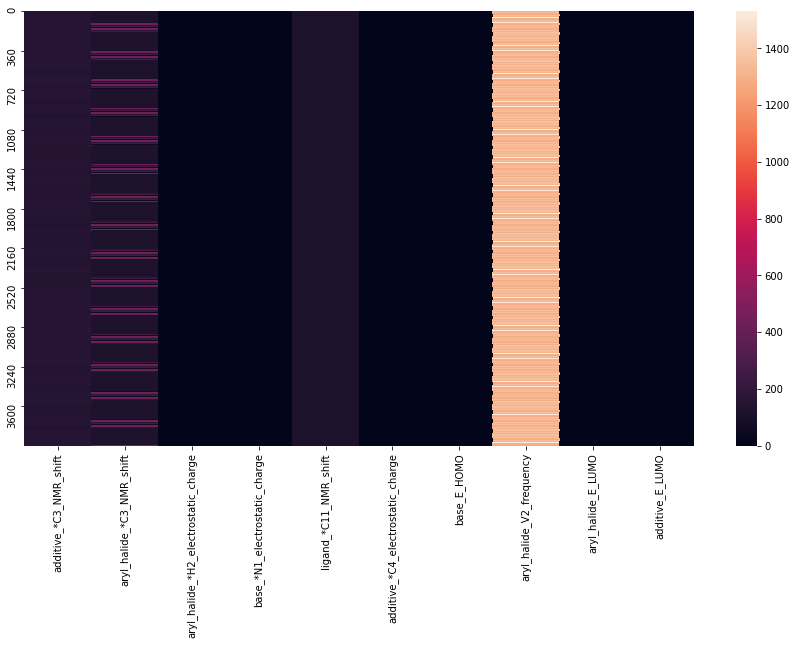

In [7]:
# Set the width and height of the figure
plt.figure(figsize=(15,8))
# Generate heatmap for the 10 columns or descriptors
sn.heatmap(data=X_data,yticklabels=360)

In [8]:
# predicting the effects of additives on yield in plate 3 using plate 1 and plate 2 as training sets  
# Predict plate 3 (index: 2520:3960))  using plate 1 and plate 2 ( index 0:2520)
X_train, X_test, y_train, y_test = X_data[:2520], X_data[2520:], y_data[:2520], y_data[2520:]
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [9]:
# Data preprocessing or normalization
# scale train set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# scale test set
X_test = scaler.transform(X_test)

<AxesSubplot:>

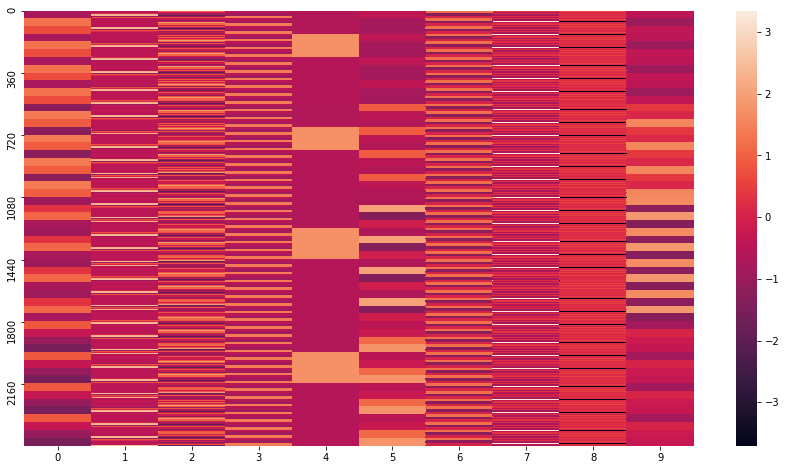

In [10]:
plt.figure(figsize=(15,8))
sn.heatmap(data=X_train,yticklabels=360)

In [11]:
X_train.shape

(2520, 10)

In [12]:
X_data

,additive_*C3_NMR_shift,aryl_halide_*C3_NMR_shift,aryl_halide_*H2_electrostatic_charge,base_*N1_electrostatic_charge,ligand_*C11_NMR_shift,additive_*C4_electrostatic_charge,base_E_HOMO,aryl_halide_V2_frequency,aryl_halide_E_LUMO,additive_E_LUMO
0,143.12,120.97,0.143,-0.755,114.03,-0.447,-0.1703,1351.720,-0.0396,-0.0487
1,143.12,120.95,0.100,-0.755,114.03,-0.447,-0.1703,1349.391,-0.0413,-0.0487
2,143.12,181.37,0.083,-0.755,114.03,-0.447,-0.1703,1346.735,-0.0429,-0.0487
3,143.12,112.08,0.137,-0.755,114.03,-0.447,-0.1703,1351.340,-0.0118,-0.0487
4,143.12,112.39,0.099,-0.755,114.03,-0.447,-0.1703,1532.172,-0.3500,-0.0487
...,...,...,...,...,...,...,...,...,...,...
3955,152.98,129.62,0.138,-0.611,114.09,-0.589,-0.1913,1311.840,-0.0391,-0.0696
3956,152.98,256.46,0.137,-0.611,114.09,-0.589,-0.1913,1305.598,-0.0383,-0.0696
3957,152.98,117.10,0.102,-0.611,114.09,-0.589,-0.1913,1298.019,-0.0380,-0.0696
3958,152.98,117.61,0.065,-0.611,114.09,-0.589,-0.1913,1295.516,-0.0390,-0.0696


In [13]:
# change yield to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
# cross validation score
scores= cross_validate(rf,X_train,y_train,scoring=('r2','neg_mean_squared_error'),cv=3)

In [15]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_neg_mean_squared_error'])

In [16]:
scores['test_r2']

array([0.69017258, 0.80762482, 0.18280069])

In [17]:
np.sqrt(-scores['test_neg_mean_squared_error'])

array([16.11375045, 12.4560202 , 21.31038148])

In [18]:
# Model Training and prediction
rf.fit(X_train,y_train) # training using 70% of the data
predicted_yield =rf.predict(X_test) # predicting yield for 30% of the data

In [19]:
# Model accuracy using root mean square error 
rmse = np.sqrt(mean_squared_error(y_test, predicted_yield )) 
print('rmse:', rmse)

rmse: 11.256062096340962


In [20]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, predicted_yield ) 
print('R^2:', R2)

R^2: 0.8099464764020295


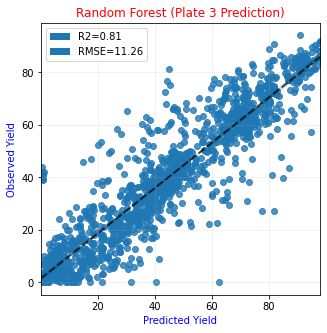

In [21]:
# from the publication RMSE = 11% and R2 = 0.83
plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("Random Forest (Plate 3 Prediction)", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.legend(handles=[R2, rmse])

In [22]:
# XGBoost the most widely used ML model in kaggle competition
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, random_state=42)

In [23]:
# Model Training and prediction
xgb.fit(X_train,y_train) # training using 70% of the data
predicted_yield2 = xgb.predict(X_test) # predicting yield for 30% of the data

In [24]:
# Model accuracy using root mean square error 
rmse2 = np.sqrt(mean_squared_error(y_test, predicted_yield2))  
print('rmse:', rmse2)

rmse: 12.578073589094215


In [25]:
# R^2 (coefficient of determination) regression score function: 
R_2 = r2_score(y_test, predicted_yield2)
print('R^2:', R_2)

R^2: 0.7626817004782398


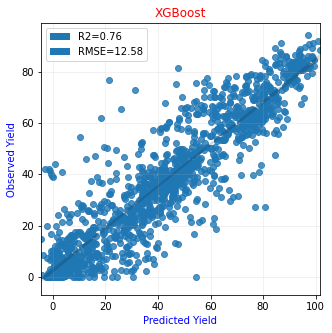

In [26]:
fig = plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield2, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.2})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("XGBoost", color='red')
plt.grid(alpha=0.2)
R_2 = mpatches.Patch(label="R2={:04.2f}".format(R_2))
rmse2 = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2))
plt.legend(handles=[R_2, rmse2])

In [27]:
# # Neural network
# sr = MLPRegressor(hidden_layer_sizes=(1200),
#                        activation='logistic',
#                        solver='sgd',
#                        max_iter=10000,
#                        random_state=42)
# sr.fit(X_train,y_train)
# predicted_yield3 = sr.predict(X_test)

In [28]:
# # R^2 (coefficient of determination) regression score function: 
# R_3 = r2_score(y_test, predicted_yield3)
# print('R^2:', R_3)

In [29]:
model = keras.Sequential([
    layers.Input(shape=(10,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [30]:
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 91,969
Trainable params: 91,969
Non-trainable params: 0
____________________________________________________

In [32]:
history= model.fit(X_train,y_train, epochs=50,validation_split=0.2)

Epoch 1/50
63/63 [==============================] - 0s 5ms/step - loss: 24.0320 - val_loss: 16.0740
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 17.3288 - val_loss: 14.8813
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 15.5500 - val_loss: 14.2218
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 13.9323 - val_loss: 13.4433
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 13.1652 - val_loss: 13.9707
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 12.6360 - val_loss: 15.2615
Epoch 7/50
63/63 [==============================] - 0s 3ms/step - loss: 12.3526 - val_loss: 14.7549
Epoch 8/50
63/63 [==============================] - 0s 3ms/step - loss: 11.9587 - val_loss: 14.7399
Epoch 9/50
63/63 [==============================] - 0s 3ms/step - loss: 11.9887 - val_loss: 14.3429
Epoch 10/50
63/63 [==============================] - 0s 3ms/step - loss: 11.6888 - val_loss: 14.8923

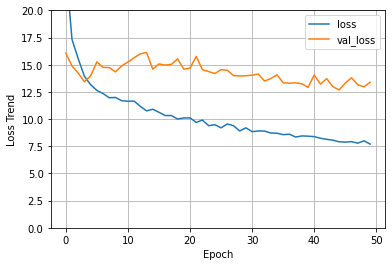

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 20])
plt.xlabel('Epoch')
plt.ylabel('Loss Trend')
plt.legend()
plt.grid(True)

In [34]:
# %%time
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     verbose=0, epochs=100)

In [35]:
# plot_loss(history)

In [36]:
predicted_yield4 = model.predict(X_test)
y_test

array([24.10905766, 32.87780619, 43.39942952, ...,  1.44008073,
       43.53836522, 69.79590237])

In [37]:
predicted_yield4

array([[11.194807 ],
       [62.995605 ],
       [78.25651  ],
       ...,
       [ 7.5789113],
       [74.38135  ],
       [88.40356  ]], dtype=float32)

In [38]:
# predicted_yield4
# for i,j in enumerate (predicted_yield4):
#     print(f'Predicted yield= {j} and Actual yield ={y_test[i]}' )
    

In [39]:
# R^2 (coefficient of determination) regression score function: 
R_4 = r2_score(y_test, predicted_yield4)
print('R^2:', R_4)

R^2: -0.31181249915513387


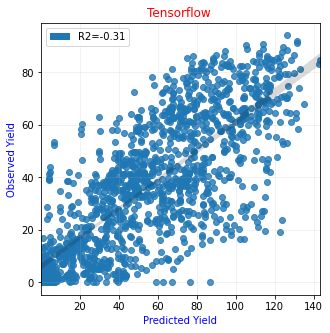

In [40]:
fig = plt.figure(figsize=(5,5))
sn.regplot(x=predicted_yield4, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.2})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.title("Tensorflow ", color='red')
plt.grid(alpha=0.2)
R_4 = mpatches.Patch(label="R2={:04.2f}".format(R_4))
# rmse2 = mpatches.Patch(label="RMSE={:04.2f}".format(rmse2))
plt.legend(handles=[R_4])